# Optimization and Simulation with DR

## optunaによる多目的関数の最適化

### 1. ライブラリ類のインポートとファイルのロード

In [40]:
%matplotlib inline

import os
import copy
import warnings

import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import datarobot as dr
from datarobot_predict.deployment import predict


import optuna
import optunahub

import japanize_matplotlib

if not os.getenv("DATAROBOT_NOTEBOOK_IMAGE"):
    print("not running in DataRobot Notebook")
    from dotenv import load_dotenv
    load_dotenv("../.env", override=True)

client = dr.Client()

seed = 71
np.random.seed(seed)
warnings.filterwarnings("ignore")
plt.rcParams.update({"figure.max_open_warning": 0})
optuna.visualization.is_available()
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
pd.set_option("display.precision", 8)

not running in DataRobot Notebook


In [41]:
targets = ["降伏強度", "引張強度"]

df = pd.read_csv("../data/opt_steel_strength.csv")

In [42]:
y_train1 = df["降伏強度"]
y_train2 = df["引張強度"]
X_train = df.drop(["ID", "降伏強度", "引張強度"], axis=1)

### 2. 予測APIを用いる上での必要な情報を準備しておきます。

In [ ]:
# 予測APIを叩くための諸々を設定する必要があります
dr.Client()
deployment_ids = ["67bc6ab2f1b3f6b73d560ff8", "67bc6ab999dbbff523b1152a"]
deployments = [dr.Deployment.get(deployment_id) for deployment_id in deployment_ids]
# 実験時間、実験回数（n_trials）での制御も可能
timeout = 15

# 結果格納用
result = []

### 3. `datarobot-predict`を使って予測APIを叩く

In [44]:
# 一回叩いてみる
predictions_1, _ = predict(deployments[0], X_train.iloc[:1])
predictions_2, _ = predict(deployments[1], X_train.iloc[:1])
display(predictions_1)
display(predictions_2)

,降伏強度_PREDICTION,DEPLOYMENT_APPROVAL_STATUS
0,2262.14794922,APPROVED


,引張強度_PREDICTION,DEPLOYMENT_APPROVAL_STATUS
0,2442.85464807,APPROVED


In [45]:
# 予測の戻り値から予測値を取り出す
predictions_1.loc[0, "降伏強度_PREDICTION"], predictions_2.loc[0, "引張強度_PREDICTION"]

(np.float64(2262.1479492188), np.float64(2442.854648066))

In [46]:
# 結果記録用のヘルパーメソッド
def update_result(result, study, sampler, pruner, n_jobs):
    dict_trial = {
        "sampler": sampler,
        "pruner": pruner,
        "n_jobs": n_jobs,
        "値": study.best_trial.value,
        "回数": len(study.trials),
        **study.best_trial.params,
    }
    result.append(dict_trial)
    print(dict_trial)
    return result

### 4. 二つのターゲットで試してみましょう
複数の最適化する対象設定します。この関数の戻り値がそれぞれ最小/大化されるようにoptunaが探索空間からいい感じの入力データを見つけてくれます。

In [47]:
stat = X_train.describe().T


def objective(trial):

    df_target = DataFrame(index=[0], columns=X_train.columns)
    for col in X_train.columns:
        low = stat.loc[col, "min"] * 0.8
        high = stat.loc[col, "max"] * 1.2
        df_target[col] = trial.suggest_float(col, low, high, step=0.01)

    pred_1 = predict(deployments[0], df_target)[0].loc[0, "降伏強度_PREDICTION"]
    pred_2 = predict(deployments[1], df_target)[0].loc[0, "引張強度_PREDICTION"]

    return pred_1, pred_2

### 5. 最適化を実行する

In [48]:
%%time
dr.Client()
sampler1 = optuna.samplers.NSGAIISampler(seed=42)
study1 = optuna.create_study(directions=["maximize","maximize"], study_name=f"{sampler1.__class__.__name__}",)
study1.optimize(objective, timeout=timeout, gc_after_trial=True)

[I 2025-02-24 14:24:19,844] A new study created in memory with name: NSGAIISampler
[I 2025-02-24 14:24:20,767] Trial 0 finished with values: [1543.7531738281, 1912.67102786] and parameters: {'炭素': 0.43, 'マンガン': 1.818, 'ケイ素': 0.438, 'クロム': 4.258, 'ニッケル': 10.498, 'モリブデン': 10.196, 'バナジウム': 5.0, '窒素': 0.16, 'ニオブ': 1.19, 'コバルト': 3.258, 'タングステン': 3.3000000000000003, 'アルミニウム': 1.058, 'チタン': 0.0}.
[I 2025-02-24 14:24:22,291] Trial 1 finished with values: [1578.7331542969, 2120.7780583869] and parameters: {'炭素': 0.47000000000000003, 'マンガン': 2.628, 'ケイ素': 0.788, 'クロム': 11.687999999999999, 'ニッケル': 10.468, 'モリブデン': 8.856, 'バナジウム': 1.81, '窒素': 0.11, 'ニオブ': 2.47, 'コバルト': 1.458, 'タングステン': 10.43, 'アルミニウム': 1.728, 'チタン': 0.27}.
[I 2025-02-24 14:24:23,291] Trial 2 finished with values: [2242.6513671875, 2517.2224850316] and parameters: {'炭素': 0.48, 'マンガン': 0.518, 'ケイ素': 0.878, 'クロム': 7.538, 'ニッケル': 10.138, 'モリブデン': 9.256, 'バナジウム': 1.08, '窒素': 0.14, 'ニオブ': 1.3, 'コバルト': 12.968, 'タングステン': 8.5, 'アルミニウム': 1.

CPU times: user 2.78 s, sys: 253 ms, total: 3.03 s
Wall time: 31.4 s


In [49]:
# 結果を一度保存します
trails_bk = [copy.deepcopy(trials) for trials in study1.trials]
for trial in study1.best_trials:
    print(trial.number, trial.values[0], trial.values[1])

2 2242.6513671875 2517.2224850316
8 2150.1494140625 2590.5291029638
9 2201.5083007812 2528.7378171679
22 2121.7985839844 2624.0831386754


In [50]:
# 使われてる最適化手法を確認
print(f"Sampler is {study1.sampler.__class__.__name__}")

Sampler is NSGAIISampler


### 6. パレート最適解を可視化してみてみましょう

In [51]:
# optunaの可視化
optuna.visualization.plot_pareto_front(study1)

<Figure size 640x480 with 0 Axes>

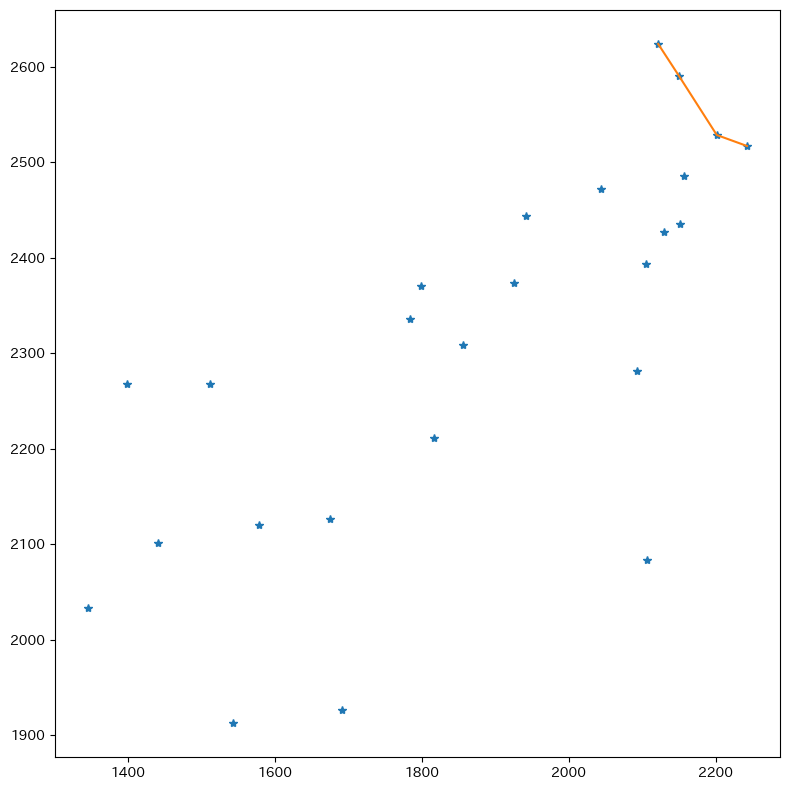

In [52]:
# 手動で可視化してみる
trial_all = []
for trial in study1.get_trials():
    trial_all.append([trial.number, trial.values[0], trial.values[1]])
trial_all = pd.DataFrame(trial_all, columns=["Iteration", "降伏強度", "引張強度"])

trial_pareto = []
for trial in study1.best_trials:
    trial_pareto.append([trial.number, trial.values[0], trial.values[1]])
trial_pareto = pd.DataFrame(trial_pareto, columns=["Iteration", "降伏強度", "引張強度"])
trial_pareto.sort_values("降伏強度", inplace=True)
# plot
plt.clf()
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(trial_all["降伏強度"], trial_all["引張強度"], linestyle="", marker="*")
ax.plot(trial_pareto["降伏強度"], trial_pareto["引張強度"])
# ax.axis("equal")
fig.tight_layout()
plt.show()
# グラフの軸は０スタートではないので、ご注意ください

### 7. OptunaHubの`Sampler`を試してみる

In [53]:
# optunaにあるNSGAIIは`RamdomSampler`で初期化して、下記は`TPESampler`で初期化している
dr.Client()
package_name = "samplers/nsgaii_with_tpe_warmup"
sampler2 = optunahub.load_module(package=package_name).NSGAIIWithTPEWarmupSampler()
study2 = optuna.create_study(
    sampler=sampler2,
    directions=["maximize", "maximize"],
    study_name=f"{sampler2.__class__.__name__}",
)
study2.optimize(objective, timeout=timeout, gc_after_trial=True)

[I 2025-02-24 14:24:51,713] A new study created in memory with name: NSGAIIWithTPEWarmupSampler
[I 2025-02-24 14:24:52,623] Trial 0 finished with values: [1321.923828125, 2026.7308466573] and parameters: {'炭素': 0.13, 'マンガン': 0.368, 'ケイ素': 0.598, 'クロム': 12.628, 'ニッケル': 9.468, 'モリブデン': 3.466, 'バナジウム': 0.53, '窒素': 0.02, 'ニオブ': 1.93, 'コバルト': 21.788, 'タングステン': 0.23, 'アルミニウム': 0.618, 'チタン': 0.8200000000000001}.
[I 2025-02-24 14:24:53,766] Trial 1 finished with values: [2140.7407226562, 2273.7366595055] and parameters: {'炭素': 0.38, 'マンガン': 0.928, 'ケイ素': 4.438, 'クロム': 13.468, 'ニッケル': 0.648, 'モリブデン': 1.426, 'バナジウム': 4.43, '窒素': 0.11, 'ニオブ': 2.25, 'コバルト': 11.437999999999999, 'タングステン': 10.790000000000001, 'アルミニウム': 1.358, 'チタン': 1.29}.
[I 2025-02-24 14:24:54,921] Trial 2 finished with values: [2245.4279785156, 2468.1222540336] and parameters: {'炭素': 0.25, 'マンガン': 2.188, 'ケイ素': 2.988, 'クロム': 12.088, 'ニッケル': 6.518, 'モリブデン': 0.776, 'バナジウム': 0.08, '窒素': 0.16, 'ニオブ': 2.04, 'コバルト': 18.328, 'タングステン': 0.

In [54]:
# CMA-ESを多目的対応した`MoCmaSampler`も試してみる
dr.Client()
package_name = "samplers/mocma"
sampler3 = optunahub.load_module(package=package_name).MoCmaSampler(seed=42)
study3 = optuna.create_study(
    sampler=sampler3,
    directions=["maximize", "maximize"],
    study_name=f"{sampler3.__class__.__name__}",
)
study3.optimize(objective, timeout=timeout, gc_after_trial=True)

[I 2025-02-24 14:25:22,510] A new study created in memory with name: MoCmaSampler
[I 2025-02-24 14:25:23,445] Trial 0 finished with values: [2231.0539550781, 2521.1467040553] and parameters: {'炭素': 0.19, 'マンガン': 3.428, 'ケイ素': 4.178, 'クロム': 12.578, 'ニッケル': 3.938, 'モリブデン': 1.816, 'バナジウム': 0.3, '窒素': 0.16, 'ニオブ': 1.8, 'コバルト': 17.078, 'タングステン': 0.22, 'アルミニウム': 2.098, 'チタン': 2.5}.
[I 2025-02-24 14:25:25,080] Trial 1 finished with values: [1611.5850830078, 2116.4301792787] and parameters: {'炭素': 0.11, 'マンガン': 0.658, 'ケイ素': 1.048, 'クロム': 6.388, 'ニッケル': 13.228, 'モリブデン': 5.016, 'バナジウム': 1.51, '窒素': 0.11, 'ニオブ': 0.41000000000000003, 'コバルト': 7.048, 'タングステン': 4.03, 'アルミニウム': 0.988, 'チタン': 2.36}.
[I 2025-02-24 14:25:26,432] Trial 2 finished with values: [2323.7631835938, 2397.1930572238] and parameters: {'炭素': 0.1, 'マンガン': 1.858, 'ケイ素': 3.378, 'クロム': 0.978, 'ニッケル': 15.318, 'モリブデン': 1.986, 'バナジウム': 0.33, '窒素': 0.18, 'ニオブ': 2.9, 'コバルト': 19.498, 'タングステン': 3.35, 'アルミニウム': 0.218, 'チタン': 2.05}.
[I 2025-0

### 8. 3つ`Sampler`の結果を比較してみる

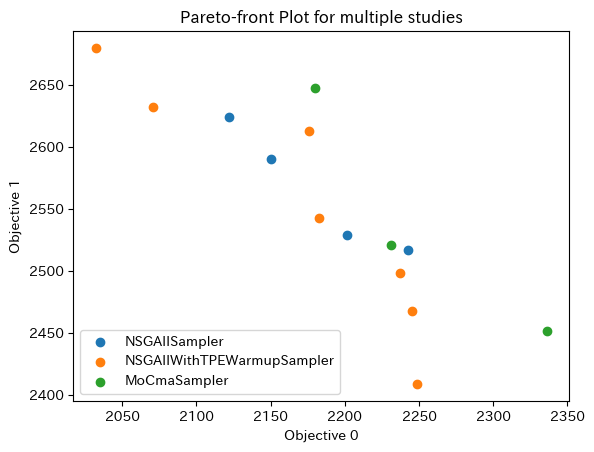

In [ ]:
from collections.abc import Sequence
from optuna.study import Study
from optuna.visualization._pareto_front import _get_pareto_front_info

# optunahub.load_module("visualization/plot_pareto_front_multi").plot_pareto_front(
#     [study1, study2, study3]
# ).show()


def plot_pareto_front_matplotlib(studies: Sequence[Study]) -> None:
    """Plot pareto front for each study using Matplotlib.

    Args:
        studies:
            A list of study object whose trials are plotted for their pareto fronts.
            The number of objectives must be 2 for all trials and must be the same on all trials.
    """

    if not all(study._is_multi_objective() for study in studies):
        raise ValueError(
            "All studies must be multi-objective. For single-objective optimization, "
            "please use plot_optimization_history instead."
        )

    if not all(
        len(studies[0].directions) == len(study.directions) for study in studies
    ):
        raise ValueError("The number of objectives must be the same for all studies.")

    if not all(len(study.directions) == 2 for study in studies):
        raise ValueError("The number of objectives must be 2 for all studies.")

    info_list = {}
    for study in studies:
        info = _get_pareto_front_info(study, include_dominated_trials=False)
        info_list[study.study_name] = info

    _get_pareto_front_plot_matplotlib(info_list)


def _get_pareto_front_plot_matplotlib(info_dict) -> None:
    title = "Pareto-front Plot for multiple studies"
    fig, ax = plt.subplots()
    ax.set_title(title)

    for key, value in info_dict.items():
        x = [values[0] for _, values in value.best_trials_with_values]
        y = [values[1] for _, values in value.best_trials_with_values]
        ax.scatter(x, y, label=key)

    ax.set_xlabel(value.target_names[0])
    ax.set_ylabel(value.target_names[1])
    ax.legend()
    plt.show()


plot_pareto_front_matplotlib([study1, study2, study3])

### 9. 3つのターゲットで最適化してみましょう

In [56]:
dr.Client()


def objective(trial):

    df_target = DataFrame(index=[0], columns=X_train.columns)
    for col in X_train.columns:
        low = stat.loc[col, "min"] * 0.8
        high = stat.loc[col, "max"] * 1.2
        df_target[col] = trial.suggest_float(col, low, high, step=0.01)

    pred_1 = predict(deployments[0], df_target)[0].loc[0, "降伏強度_PREDICTION"]
    pred_2 = predict(deployments[1], df_target)[0].loc[0, "引張強度_PREDICTION"]

    return pred_1, pred_2, df_target["コバルト"]


samplers = [
    optuna.samplers.RandomSampler(),
    optuna.samplers.TPESampler(),
    optuna.samplers.NSGAIISampler(),
]
studies = []
for sampler in samplers:
    print("--------------------")
    print(f"最適化 Sampler: {sampler.__class__.__name__}")
    study = optuna.create_study(
        sampler=sampler,
        study_name=f"{sampler.__class__.__name__}",
        directions=["maximize", "maximize", "minimize"],
    )
    study.optimize(objective, n_trials=50)
    studies.append(study)

[I 2025-02-24 14:25:54,239] A new study created in memory with name: RandomSampler


--------------------
最適化 Sampler: RandomSampler


[I 2025-02-24 14:25:55,269] Trial 0 finished with values: [2033.2778320312, 2203.9238479494, 8.588] and parameters: {'炭素': 0.2, 'マンガン': 2.948, 'ケイ素': 1.808, 'クロム': 16.108, 'ニッケル': 16.608, 'モリブデン': 0.8460000000000001, 'バナジウム': 1.68, '窒素': 0.0, 'ニオブ': 2.15, 'コバルト': 8.588, 'タングステン': 7.0600000000000005, 'アルミニウム': 2.0180000000000002, 'チタン': 1.19}.
[I 2025-02-24 14:25:56,084] Trial 1 finished with values: [1773.0776367188, 2150.8236942623, 6.658] and parameters: {'炭素': 0.12, 'マンガン': 1.178, 'ケイ素': 4.5680000000000005, 'クロム': 8.508, 'ニッケル': 10.308, 'モリブデン': 11.456, 'バナジウム': 4.94, '窒素': 0.14, 'ニオブ': 0.47000000000000003, 'コバルト': 6.658, 'タングステン': 10.43, 'アルミニウム': 0.248, 'チタン': 2.7600000000000002}.
[I 2025-02-24 14:25:57,245] Trial 2 finished with values: [1396.5594482422, 2174.7600508706, 12.388] and parameters: {'炭素': 0.32, 'マンガン': 0.328, 'ケイ素': 3.2680000000000002, 'クロム': 11.447999999999999, 'ニッケル': 20.558, 'モリブデン': 9.836, 'バナジウム': 0.1, '窒素': 0.06, 'ニオブ': 1.74, 'コバルト': 12.388, 'タングステン': 7.29, 'アル

--------------------
最適化 Sampler: TPESampler


[I 2025-02-24 14:26:44,602] Trial 0 finished with values: [1791.4665527344, 2317.3748104375, 10.228] and parameters: {'炭素': 0.44, 'マンガン': 0.038, 'ケイ素': 4.578, 'クロム': 9.517999999999999, 'ニッケル': 1.8880000000000001, 'モリブデン': 6.686, 'バナジウム': 0.6, '窒素': 0.1, 'ニオブ': 2.48, 'コバルト': 10.228, 'タングステン': 4.29, 'アルミニウム': 1.318, 'チタン': 0.11}.
[I 2025-02-24 14:26:45,902] Trial 1 finished with values: [1907.4455566406, 2510.9511490897, 18.698] and parameters: {'炭素': 0.41000000000000003, 'マンガン': 1.118, 'ケイ素': 2.238, 'クロム': 18.308, 'ニッケル': 7.888, 'モリブデン': 0.116, 'バナジウム': 3.5, '窒素': 0.16, 'ニオブ': 0.19, 'コバルト': 18.698, 'タングステン': 9.23, 'アルミニウム': 0.518, 'チタン': 2.7800000000000002}.
[I 2025-02-24 14:26:46,850] Trial 2 finished with values: [1991.0699462891, 2484.2265124561, 9.068] and parameters: {'炭素': 0.29, 'マンガン': 1.838, 'ケイ素': 3.258, 'クロム': 17.608, 'ニッケル': 10.177999999999999, 'モリブデン': 5.496, 'バナジウム': 1.86, '窒素': 0.07, 'ニオブ': 1.11, 'コバルト': 9.068, 'タングステン': 7.7, 'アルミニウム': 0.978, 'チタン': 2.36}.
[I 2025-02-24 14

--------------------
最適化 Sampler: NSGAIISampler


[I 2025-02-24 14:27:41,195] Trial 0 finished with values: [1389.2996826172, 1805.5607388594, 4.918] and parameters: {'炭素': 0.02, 'マンガン': 1.428, 'ケイ素': 1.778, 'クロム': 9.898, 'ニッケル': 23.928, 'モリブデン': 8.006, 'バナジウム': 3.0500000000000003, '窒素': 0.07, 'ニオブ': 2.73, 'コバルト': 4.918, 'タングステン': 1.41, 'アルミニウム': 1.058, 'チタン': 0.6900000000000001}.
[I 2025-02-24 14:27:42,118] Trial 1 finished with values: [1565.5378417969, 2246.2981826902, 13.107999999999999] and parameters: {'炭素': 0.17, 'マンガン': 0.608, 'ケイ素': 4.978, 'クロム': 12.828, 'ニッケル': 7.378, 'モリブデン': 6.316, 'バナジウム': 1.11, '窒素': 0.02, 'ニオブ': 2.13, 'コバルト': 13.107999999999999, 'タングステン': 7.5, 'アルミニウム': 1.078, 'チタン': 0.5}.
[I 2025-02-24 14:27:42,923] Trial 2 finished with values: [1426.6038818359, 2049.7259632544, 5.948] and parameters: {'炭素': 0.1, 'マンガン': 0.738, 'ケイ素': 4.0680000000000005, 'クロム': 9.937999999999999, 'ニッケル': 17.448, 'モリブデン': 10.556000000000001, 'バナジウム': 2.42, '窒素': 0.17, 'ニオブ': 0.07, 'コバルト': 5.948, 'タングステン': 5.95, 'アルミニウム': 0.358000000000

In [62]:
# パレート曲線を描いてみる
# m = optunahub.load_module("visualization/plot_pareto_front_multi")
# fig = m.plot_pareto_front(studies)
# fig.show()

In [ ]:
# `HyperVolume`を描いてみる
# 平均点からどこまで改善できたかを確認する
reference_point = [
    df["降伏強度"].mean(),
    df["引張強度"].mean(),
    df["コバルト"].mean(),
]
# m = optunahub.load_module("visualization/plot_hypervolume_history_multi")
# fig = m.plot_hypervolume_history(studies, reference_point)
# fig.show()

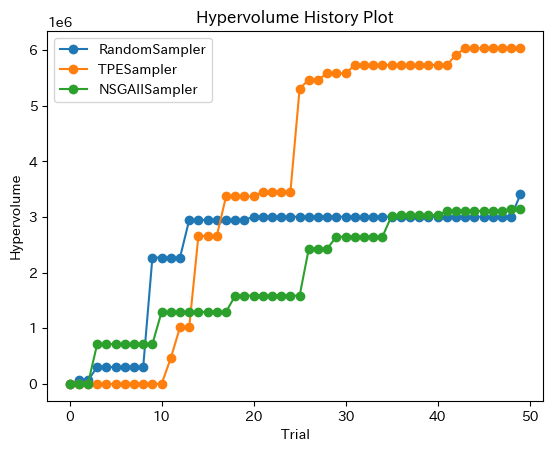

In [68]:
from optuna.visualization._hypervolume_history import _get_hypervolume_history_info
from typing import NamedTuple


class _HypervolumeHistoryInfo(NamedTuple):
    trial_numbers: list[int]
    values: list[float]
    study_name: str


def plot_hypervolume_history_matplotlib(
    studies: Sequence[Study], reference_point: Sequence[float]
):
    """Plot hypervolume history for each study using Matplotlib.

    Args:
        studies:
            A list of study object whose trials are plotted for their hypervolumes.
            The number of objectives must be 2 or more for all trials and must be the same on all trials.

        reference_point:
            A reference point to use for hypervolume computation.
            The dimension of the reference point must be the same as the number of objectives.

    Returns:
        A Matplotlib figure object.
    """
    if not all(study._is_multi_objective() for study in studies):
        raise ValueError(
            "All studies must be multi-objective. For single-objective optimization, "
            "please use plot_optimization_history instead."
        )

    if not all(len(study.directions) == len(study.directions) for study in studies):
        raise ValueError("The number of objectives must be the same for all studies.")

    if len(reference_point) != len(studies[0].directions):
        raise ValueError(
            "The dimension of the reference point must be the same as the number of objectives."
        )

    info_list = []
    for study in studies:
        info_ = _get_hypervolume_history_info(
            study, np.asarray(reference_point, dtype=np.float64)
        )
        info_list.append(
            _HypervolumeHistoryInfo(info_.trial_numbers, info_.values, study.study_name)
        )

    return _get_hypervolume_history_plot_matplotlib(info_list)


def _get_hypervolume_history_plot_matplotlib(info_list: list[_HypervolumeHistoryInfo]):
    fig, ax = plt.subplots()
    ax.set_title("Hypervolume History Plot")
    ax.set_xlabel("Trial")
    ax.set_ylabel("Hypervolume")

    for info in info_list:
        ax.plot(info.trial_numbers, info.values, marker="o", label=info.study_name)

    ax.legend()
    plt.show()
    plt.close(fig)  # Close the figure to prevent it from displaying twice


plot_hypervolume_history_matplotlib(studies, reference_point)

In [59]:
# This is the end of this code...